In [33]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.transforms import GaussianBlur
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, zoom, mean as ndimage_mean
from skimage.transform import resize
import cv2


In [183]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
# Functions for pixellation

def upsample_nearest(image, new_width, new_height):

    old_height, old_width = image.shape[-2:]
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Create the coordinate grid for the new image
    x_indices = (np.arange(new_width) / scale_x).astype(int)
    y_indices = (np.arange(new_height) / scale_y).astype(int)

    # Use advanced indexing to map the input pixels to the new grid
    upsampled_image = image[:,y_indices[:, None], x_indices]
    return upsampled_image

def downsample_to_fixed_size(image, target_size):

    num_channels, input_height, input_width = image.shape
    target_rows, target_cols = target_size

    # Calculate the scaling factors
    row_scale = input_height / target_rows
    col_scale = input_width / target_cols

    # Create an empty array for the downsampled image
    downsampled_image = np.zeros((num_channels,target_rows, target_cols), dtype=np.float32)

    for row in range(target_rows):
        for col in range(target_cols):
            # Determine the boundaries of the region in the original image
            row_start = int(row * row_scale)
            row_end = int((row + 1) * row_scale)
            col_start = int(col * col_scale)
            col_end = int((col + 1) * col_scale)

            # Extract the region and compute the average for each channel
            region = image[:,row_start:row_end, col_start:col_end]
            downsampled_image[:,row, col] = region.mean(axis=(1, 2))

    return downsampled_image.astype(image.dtype)



In [ ]:
class coldDiff:
    def __init__(self, steps=300, size=28, loss_type='L2'):
        self.steps = steps
        self.size = size
        self.loss_type = loss_type
        
    def blur(self, x0, t, base_sigma=1.0):
        sigma_t = torch.sqrt(t*base_sigma**2).detach().cpu().numpy()
        x0_cpu = x0.detach().cpu().numpy()
        blurred_imgs = [gaussian_filter(x0_cpu[i], sigma=(0, sigma_t[i], sigma_t[i])) for i in range(len(sigma_t))]
        return torch.from_numpy(np.stack(blurred_imgs)).to(device)
        # return GaussianBlur(5, sigma_t)

    def vignette(self,x0,t): # Masking in the paper
        x0_cpu = x0.detach().cpu().numpy()
        

        pass


    def pixellate(self,x0,t,final_resolution=4): # Super resolution in the paper

        original_w,original_h = x0.shape[2],x0.shape[3]
                
        w,h = original_w,original_h
        pixellated_imgs = x0.detach().cpu().numpy()

        # Convert to list of numpy arrays
        pixellated_imgs = [pixellated_imgs[i].astype(np.float32) for i in range(len(pixellated_imgs))]
        while w > final_resolution and h > final_resolution:
            if(w//2 < final_resolution and h//2 < final_resolution):
                target_width = final_resolution
                target_height = final_resolution
            else:
                target_width = w//2
                target_height = h//2
            # Downsample the image using average pooling
            for i in range(len(pixellated_imgs)):
                if t[i] > 0:
                    
                    pixellated_imgs[i] = downsample_to_fixed_size(pixellated_imgs[i], (target_height, target_width))
                    print(f"pixellated_imgs[{i}].shape:{pixellated_imgs[i].shape}, target_width:{target_width}, target_height:{target_height}")
             
            w,h = w//2,h//2
            
            t = t - 1    
        # Up sample the image to the original resolution (original_w,original_h) using nearest neighbour interpolation

        pixellated_imgs = [upsample_nearest(pixellated_imgs[i], original_w, original_h) for i in range(len(pixellated_imgs))]


        return torch.from_numpy(np.stack(pixellated_imgs)).to(device)
    
    def inpainting(self,x_0,t,base_variance=1): #Base variance is beta in the paper
        w,h = x_0.shape[2],x_0.shape[3]
        center_x,center_y = np.random.randint(0,w, size = x_0.shape[0]),np.random.randint(0,h,x_0.shape[0])
        variance = base_variance + 0.3*t
        # 2d gaussian curve with center at rand_x,rand_y and peak value = 1, discretized 

        x_0 = x_0.detach().cpu().numpy()
        gaussian_mask = np.zeros_like(x_0, dtype=float)

        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        gaussian = torch.stack([1-np.exp(-((x - center_x[i])**2 + (y - center_y[i])**2) / (2 * variance[i])) for i in range(len(x_0))]).numpy()

        # Add extra channel dimension as 2nd dimension
        gaussian = gaussian[:,None,:,:]

        

        # Apply the mask to the image
        inpainted_imgs = x_0 * gaussian

        return torch.from_numpy(inpainted_imgs).to(device)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,)) #Should this be self.steps+1?
    
    def sample(self, model, batch_size):
        output_shape = (batch_size, 1, 28, 28)
        t = self.steps
        model.eval()
        #x_prev = x_t
        # For now just use a black image
        x_prev = torch.zeros(output_shape).to(device)
        for s in tqdm(range(t, 0, -1)):
            s_ = (torch.ones(batch_size)*s).long().to(device)
            pred_x0 = model(x_prev, s_)
            x_prev = x_prev - self.blur(pred_x0, s_) + self.blur(pred_x0, s_-1)
        return pred_x0

In [161]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [162]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [163]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [164]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [165]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [166]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [167]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [168]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [203]:
EPOCHS = 100
batch_size = 8
image_size = 28
learning_rate = 5e-5
steps = 4


# Import dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
diffusion = coldDiff(size=image_size, steps = steps)
length = len(train_loader)
print(length)

train_losses = []
val_losses = []



7500


tensor([2, 2, 1, 2, 3, 2, 3, 3])


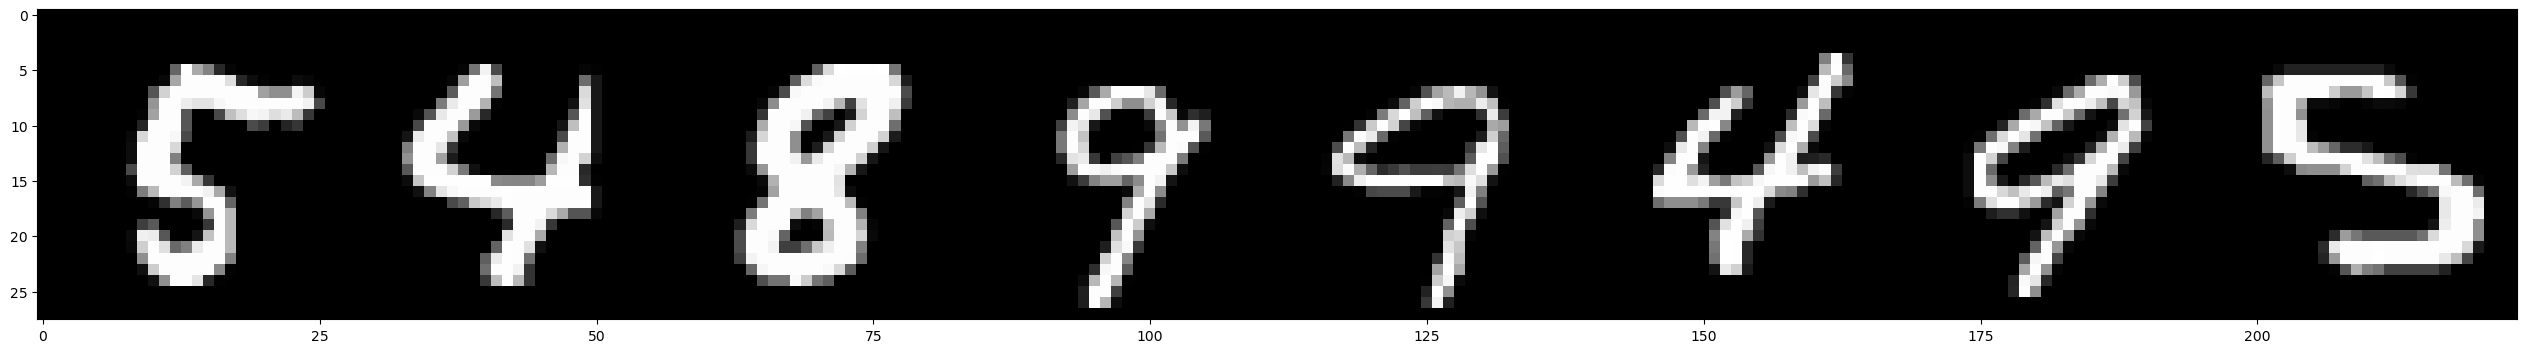

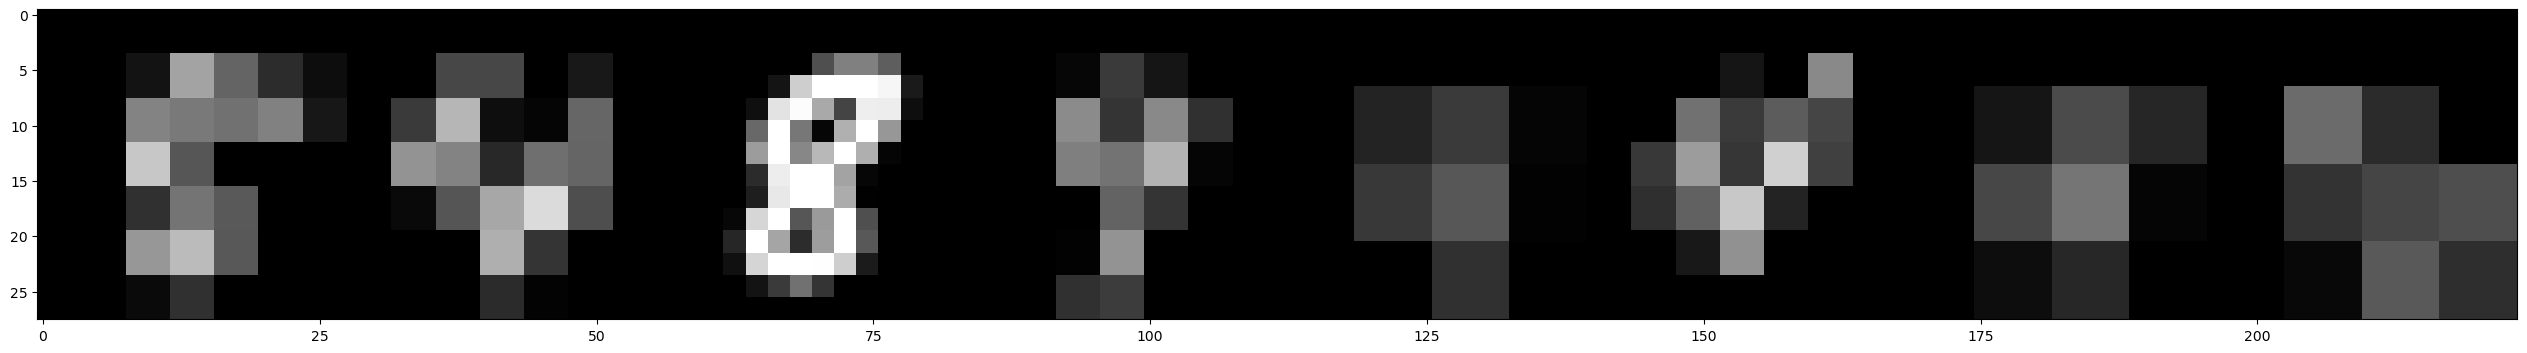

In [204]:
for x, _ in train_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0])
    print(t)
    # Plot the images
    plot_images(x)
    x_t = diffusion.pixellate(x, t)
    plot_images(x_t)
    break

Epoch  0


100%|██████████| 4/4 [00:00<00:00, 44.95it/s]


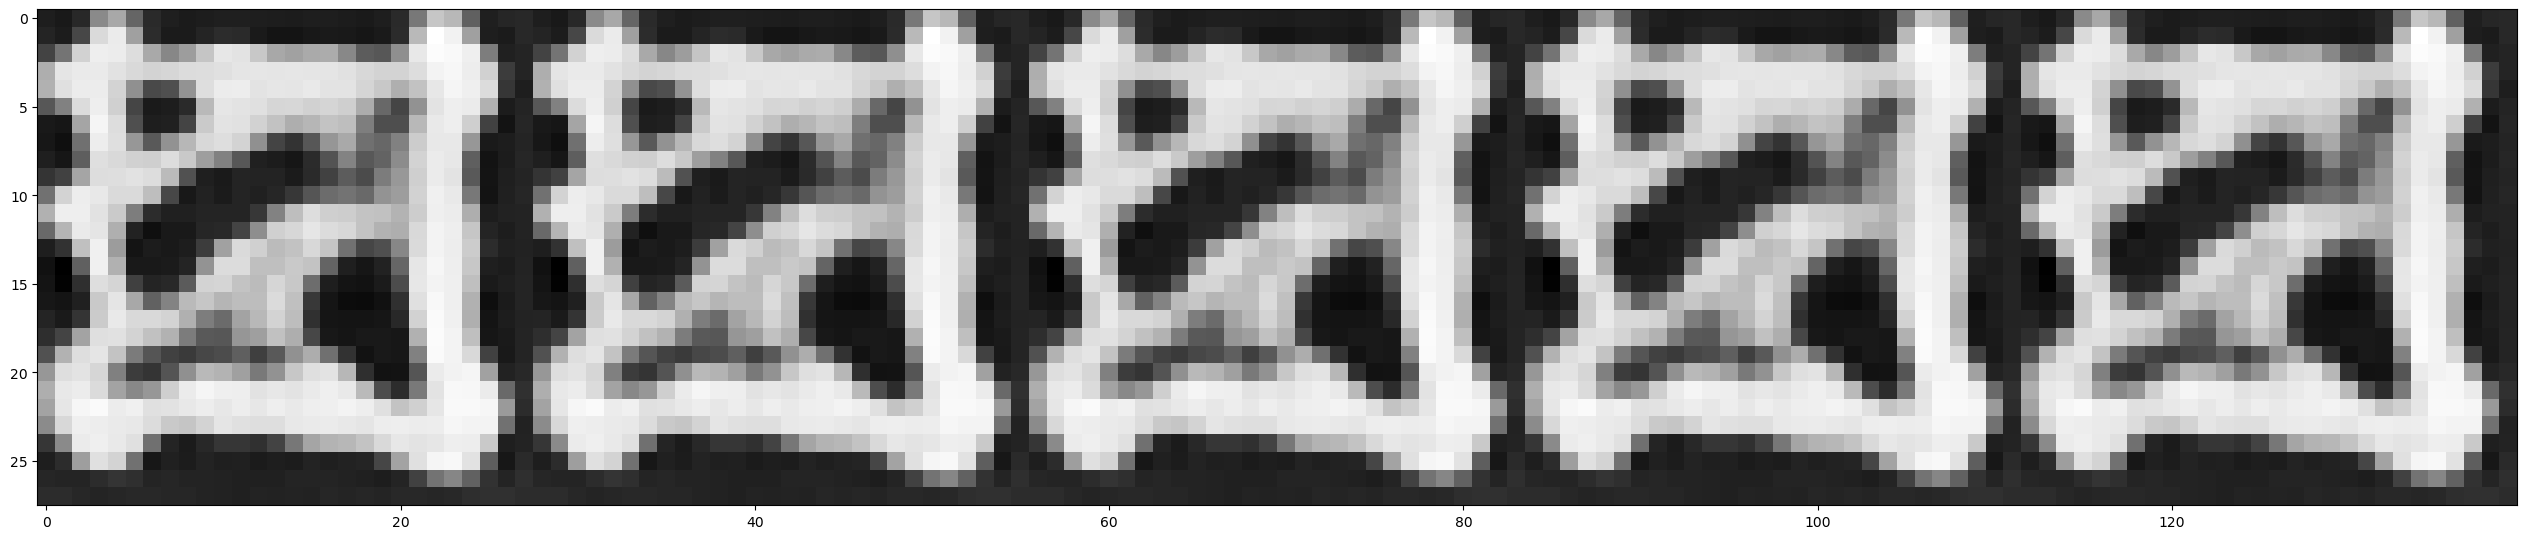

Epoch [1/100] | Train Loss: 0.0660 | Validation Loss: 0.0971
Epoch  1


100%|██████████| 7500/7500 [11:00<00:00, 11.35it/s]


Epoch [2/100] | Train Loss: 0.0529 | Validation Loss: 0.1124
Epoch  2


100%|██████████| 7500/7500 [10:27<00:00, 11.96it/s]


Epoch [3/100] | Train Loss: 0.0502 | Validation Loss: 0.1104
Epoch  3


100%|██████████| 4/4 [00:00<00:00, 63.97it/s]


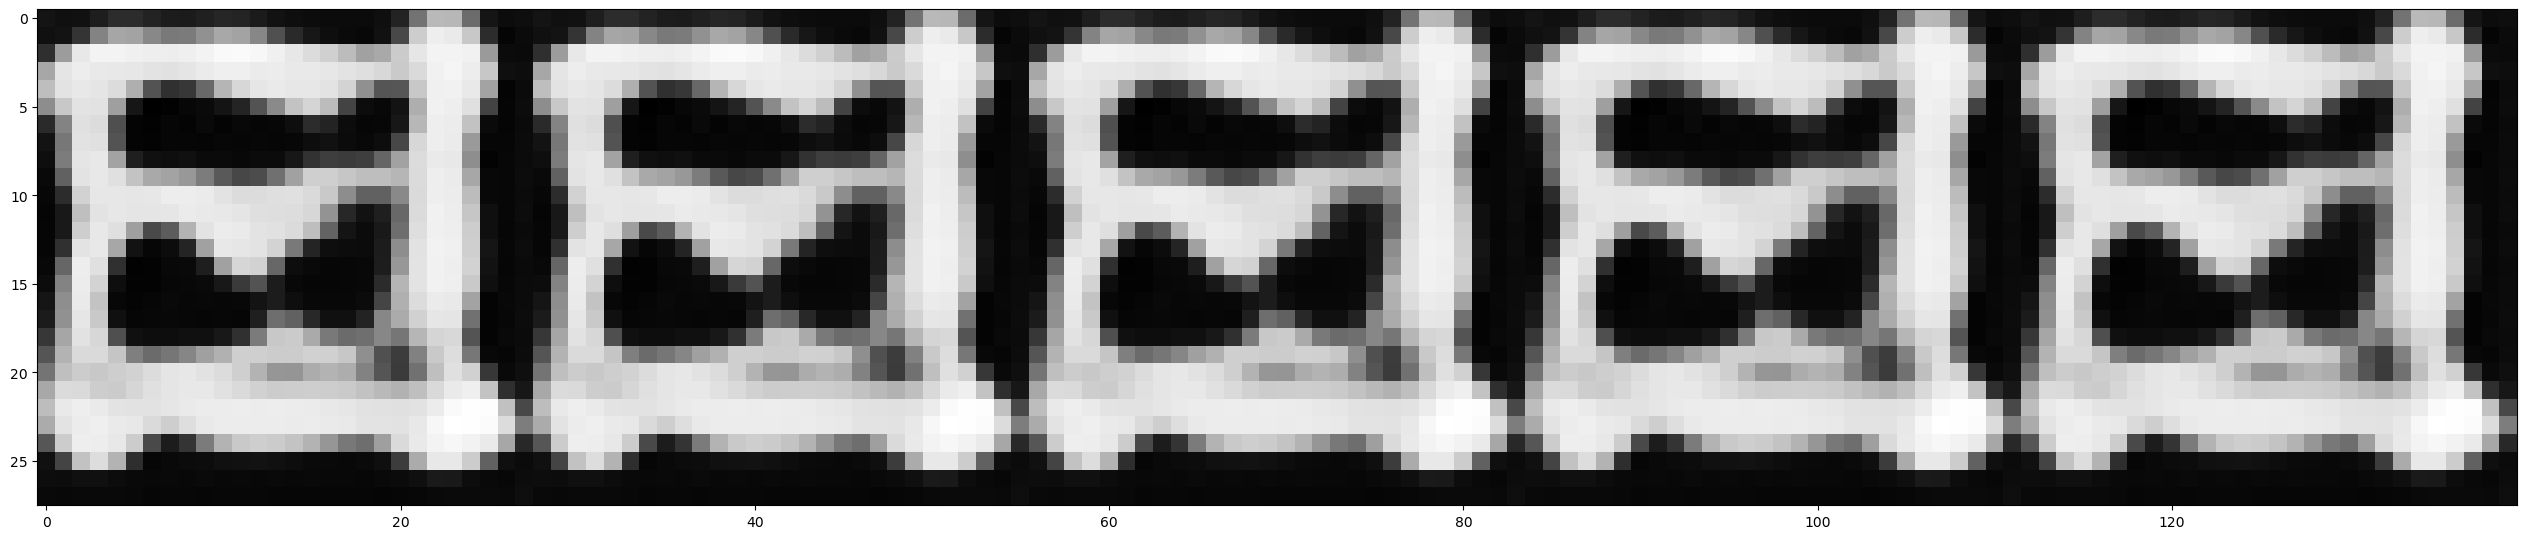

Epoch [4/100] | Train Loss: 0.0484 | Validation Loss: 0.1082
Epoch  4


100%|██████████| 7500/7500 [10:25<00:00, 11.99it/s]


Epoch [5/100] | Train Loss: 0.0469 | Validation Loss: 0.1167
Epoch  5


100%|██████████| 7500/7500 [10:19<00:00, 12.11it/s]


Epoch [6/100] | Train Loss: 0.0459 | Validation Loss: 0.1176
Epoch  6


 36%|███▌      | 2672/7500 [03:48<07:48, 10.31it/s]

In [ ]:


for epoch in range(EPOCHS):
    print("Epoch ",epoch)
    train_loss = 0
    for x, _ in tqdm(train_loader):
        optimizer.zero_grad()
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        #x_t = diffusion.blur(x, t)
        x_t = diffusion.pixellate(x,t)
        pred = model(x_t, t)
        loss = loss_fn(pred, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for x, _ in val_loader:
            #print(type(x))
            #print(x.shape)
            x = x.to(device)
            t = diffusion.sample_timesteps(x.shape[0]).to(device)
            x_t = diffusion.blur(x, t)
            pred = model(x_t, t)
            batch_val_loss = loss_fn(pred, x)
            val_loss += batch_val_loss.item()
    
    # Sample only every 3 epochs for opt purposes
    if epoch%3 == 0:
        sampled_images = diffusion.sample(model, batch_size=5)
        plot_images(sampled_images)
        
    # Save loss
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    print(f"Epoch [{epoch+1}/100] | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

In [ ]:
torch.save(model.state_dict(), './Models/DM/coldDiff1')

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.94it/s]


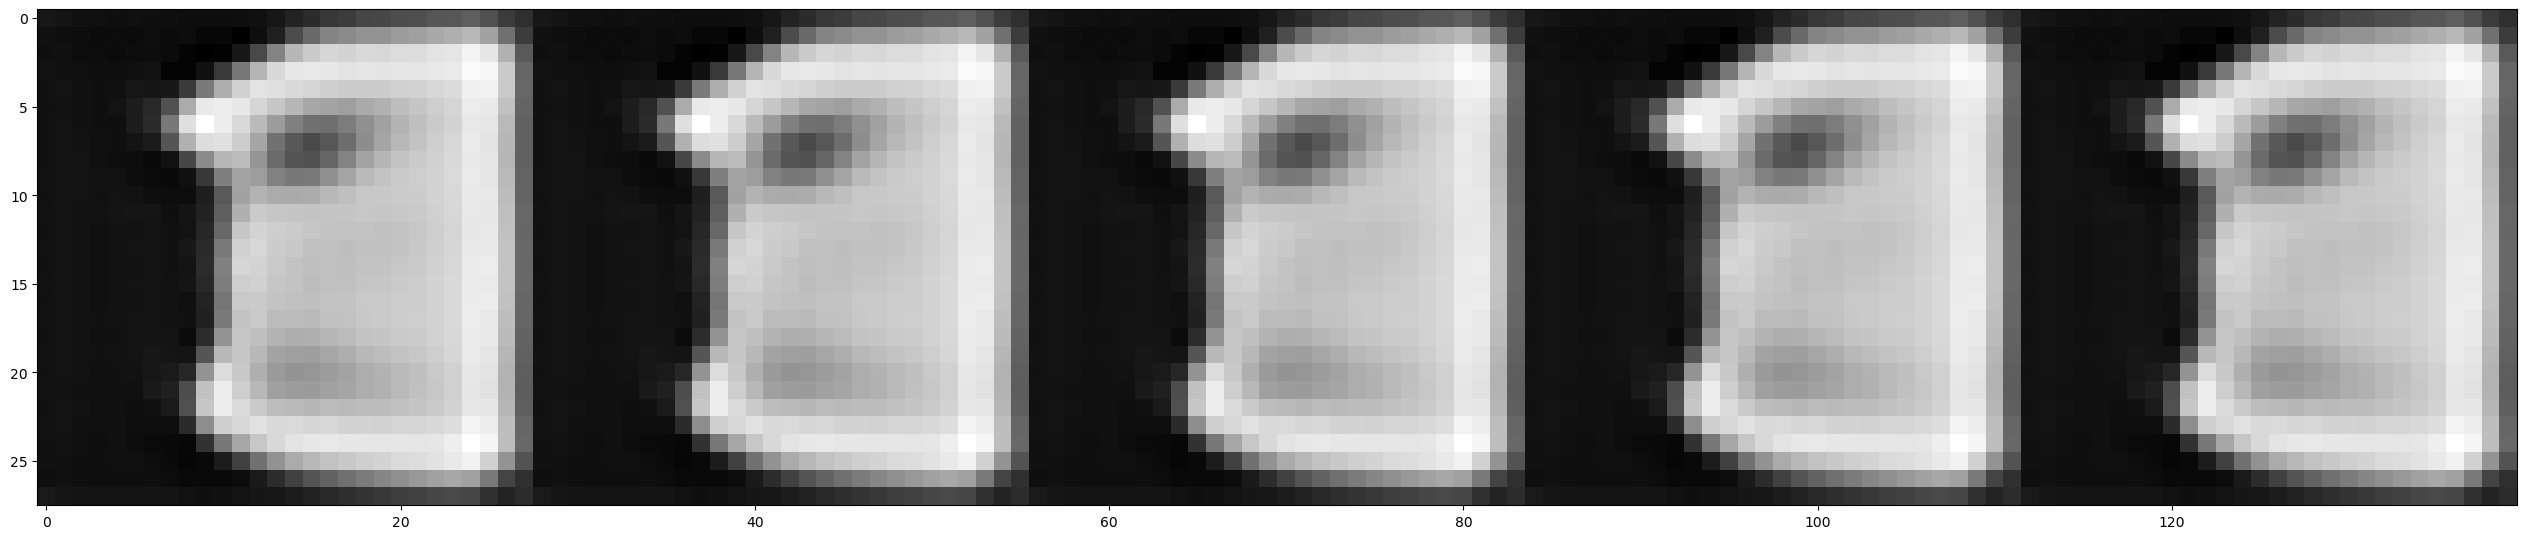

In [69]:
diff2 = coldDiff()
sampled_images = diff2.sample(model, batch_size=5)
plot_images(sampled_images)

In [ ]:
# Manually create loss record since I forgot to add the append.
train_losses = []
val_losses = []

In [ ]:
### Save model
torch.save(model.state_dict(), './Models/DM/diffusion2')

### FID

In [ ]:
from inception import InceptionV3
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm


def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1-mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1+sigma2- 2*covmean)
    return fid

def get_activations(images, model, batch_size=32, dims=2048, device='cuda'):
    model.eval()
    pred_arr = np.empty((len(images), dims))
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            start = i
            end = i+batch_size
            batch = images[start:end].to(device)
            #print(batch.size())
            #raise
            pred = model(batch)[0]
            pred = F.adaptive_avg_pool2d(pred, output_size=(1,1))
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start:end] = pred
    return pred_arr

#inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.fc = torch.nn.Identity()
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

In [40]:
original_images = []
generated_images = []

model.eval()
with torch.no_grad():
    for x, t in train_loader:
        original_images.append(x)
        sampled = diffusion.sample(model, n=x.shape[0])
        generated_images.append(sampled)
        
original_images = torch.stack(original_images)
generated_images = torch.stack(generated_images)

999it [01:06, 14.93it/s]
999it [01:07, 14.79it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.67it/s]
999it [01:09, 14.44it/s]
999it [01:08, 14.52it/s]
999it [01:09, 14.33it/s]
999it [01:09, 14.46it/s]
999it [01:08, 14.56it/s]
999it [01:09, 14.27it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.37it/s]
999it [01:08, 14.57it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.56it/s]
999it [01:11, 13.98it/s]
999it [01:09, 14.41it/s]
999it [01:08, 14.66it/s]
999it [01:07, 14.71it/s]
999it [01:09, 14.32it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.58it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.36it/s]
999it [01:08, 14.49it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.53it/s]
999it [01:10, 14.13it/s]
999it [01:10, 14.15it/s]
999it [01:09, 14.46it/s]
999it [01:10, 14.16it/s]
999it [01:11, 13.98it/s]
999it [01:13, 13.59it/s]
999it [01:15, 13.22it/s]
999it [01:11, 13.94it/s]
999it [01:11, 14.01it/s]
999it [01:11, 13.89it/s]
999it [01:10, 14.09it/s]
999it [01:09, 14.30it/s]
999it [01:08, 14.50it/s]


KeyboardInterrupt: 

In [49]:
generated_images.size()

torch.Size([111, 32, 1, 28, 28])

In [19]:
original_images = torch.stack(original_images[:-1])
generated_images = torch.stack(generated_images)

NameError: name 'original_images' is not defined

In [54]:
transform = torchvision.transforms.Compose([
    #transforms.Grayscale(3)
    torchvision.transforms.Lambda(lambda x: x.repeat(1, 1, 3, 1, 1))
])

original_transformed = []
generated_transformed = []

for i in range(len(generated_images)):
    original_transformed.append(transform(original_images[i].squeeze()))
    generated_transformed.append(transform(generated_images[i].squeeze()))
    
original_transformed = torch.stack(original_transformed)
generated_transformed = torch.stack(generated_transformed)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [50]:
generated_transformed.size()

torch.Size([111, 96, 28, 28])

In [47]:
generated_transformed = generated_transformed/255 - 1

In [48]:
import numpy as np

original_activations = get_activations(original_transformed, inception_model, device=device)
generated_activations = get_activations(generated_transformed, inception_model, device=device)

# Calculate mean and covariance of the activations
mu1 = np.mean(original_activations, axis=0)
sigma1 = np.cov(original_activations, rowvar=False)
mu2 = np.mean(generated_activations, axis=0)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print('FID score:', fid_score)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 96, 299, 299] to have 3 channels, but got 96 channels instead

### Use GMM to sample images

In [20]:
from sklearn.mixture import GaussianMixture

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

diffusion = coldDiff()

fully_degraded_images = []

for x, _ in test_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0]).to(device)
    x_t = diffusion.blur(x, t)
    flattened_images = x_t.view(x_t.size(0), -1).detach().cpu().numpy()
    fully_degraded_images.extend(flattened_images)

    
fully_degraded_images = np.array(fully_degraded_images)

gmm = GaussianMixture(n_components=3)
gmm.fit(fully_degraded_images)

GaussianMixture(n_components=3)

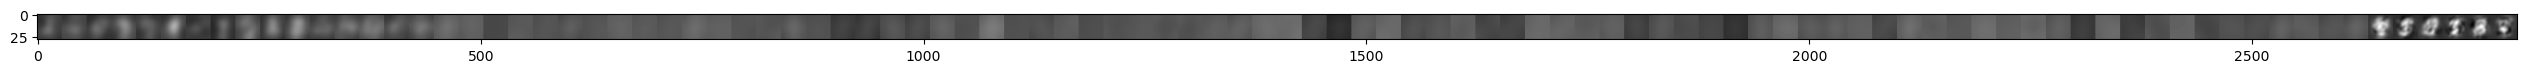

In [22]:
n_samples = 100
sampled_images = gmm.sample(n_samples)[0]
initial_images = torch.tensor(sampled_images).float().to(device)
initial_images = initial_images.view(n_samples, 1, 28, 28)
plot_images(initial_images)

In [15]:
initial_images.shape

torch.Size([100, 1])

In [17]:
sampled_intensities = gmm.sample(n_samples)

In [19]:
len(sampled_intensities)

2

In [23]:
import joblib

In [24]:
joblib.dump(gmm, 'Models/DM/gmm_blur_coldDiff.joblib')

['Models/DM/gmm_blur_coldDiff.joblib']